## Librairies nécessaires

In [5]:
import kagglehub
import os

!pip install wfdb
!pip install ast
import wfdb
import ast
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

  Using cached AST-0.0.2.tar.gz (19 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
! pip install -r requirements.txt

## Fonctions utiles

In [ ]:
def concatenate_delete(A, B, axe = 0):
    C = np.concatenate([A, B], axis = axe)
    del A, B
    return C

In [12]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data]) #nous ne gardons pas les metadonnées par soucis de mémoire
    return data

def load_raw_data_batched(df, sampling_rate, path, batch_num=0):
    """
        sampling_rate: frequence des echantillons
        batch_num: nombre de batchs a charger
        function legerement optimisée par rapport à la 1ere version (load_raw_data)
    """
    batch_size = len(df) // 8
    batch_df = df[ batch_num*batch_size : (batch_num + 1)*batch_size]
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + f) for f in batch_df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in batch_df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data


def plot_signals(ecg_signal):
    num_leads = ecg_signal.shape[1]
    plt.figure(figsize=(15, 5 * num_leads))
    for i in range(num_leads):
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(ecg_signal[:, i])
        plt.title(f"Lead {i + 1}")
        plt.ylabel("Amplitude")
        plt.grid(True)

def normalise_signaux(signaux):
    """
    Normalise les signaux ECG sur l'axes des canaux
    """

    moyennes = np.mean(signaux, axis=2, keepdims=True)
    ecarts_types = np.std(signaux, axis=2, keepdims=True) 
    
    signaux_normalises = (signaux - moyennes) / ecarts_types

    return signaux_normalises

In [ ]:
record[1] # exemple de metadata

{'fs': 500,
 'sig_len': 5000,
 'n_sig': 12,
 'base_date': None,
 'base_time': None,
 'units': ['mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV'],
 'sig_name': ['I',
  'II',
  'III',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'comments': []}

## Chargement de donnée

In [13]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount(root)

# create permanent directory in gdrive
#data_dir_path = '/MyDrive/Colab Notebooks/'
data_dir_path = '/MyDrive/' # for shared folder
os.makedirs(os.path.join(root,data_dir_path), exist_ok=True)
os.listdir(os.path.join(root,data_dir_path))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


[]

In [ ]:
#!unzip -q "/content/gdrive/MyDrive/Colab Notebooks/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip"

#for shared data
!unzip -q "/content/gdrive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip"

In [ ]:
path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate= [100,500]

# load and convert annotation data
Y = pd.read_csv(path+'/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
np.save('ptbxl_ids.npy', Y)

In [ ]:
X100 = load_raw_data(Y, sampling_rate[0], path)
np.save('ptbxl_signals_100hz.npy', X100)
del X100

In [ ]:
X500 = load_raw_data(Y, sampling_rate[1], path)
np.save('ptbxl_signals_500hz.npy', X500)
del X500

In [7]:
#copy on my drive
!cd "/content/gdrive/MyDrive/Colab Notebooks/"
#!cp ptbxl_signals_100hz.npy
#!cp /content/ptbxl_ids.npy

In [8]:
# chargement des données
X_100 = np.load('/content/gdrive/MyDrive/ptbxl_signals_100hz.npy')
#X_500 = np.load('ptbxl_signals_500hz.npy')

#load the IDs (Y data)
Y = np.load('/content/gdrive/MyDrive/ptbxl_ids.npy', allow_pickle=True)
X = np.copy(X_100)
del X_100

Nous travaillerons par la suite qu'avec les signaux à faible fréquence($100$Hz) par manque de moyen(computationnel) d'utiliser les $500$ Hz.

In [ ]:
n, p, d = X.shape
print(f"Il y en a {n} patients, {p} signaux, {d} leads")

Il y en a 21799 patients, 1000 signaux, 12 leads


## Visualisation d'un échantillon

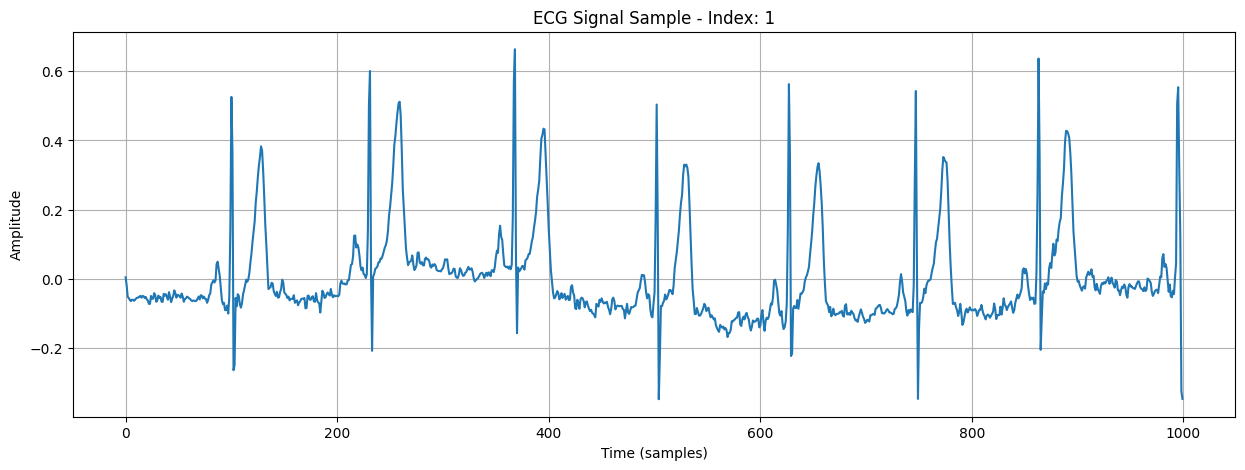

In [ ]:
num_sample = 1

ecg_signal = X[num_sample]

#Plot ECG signal
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal[:, 0])  # 1er col du ECG
plt.title(f"ECG Signal Sample - Index: {num_sample}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)


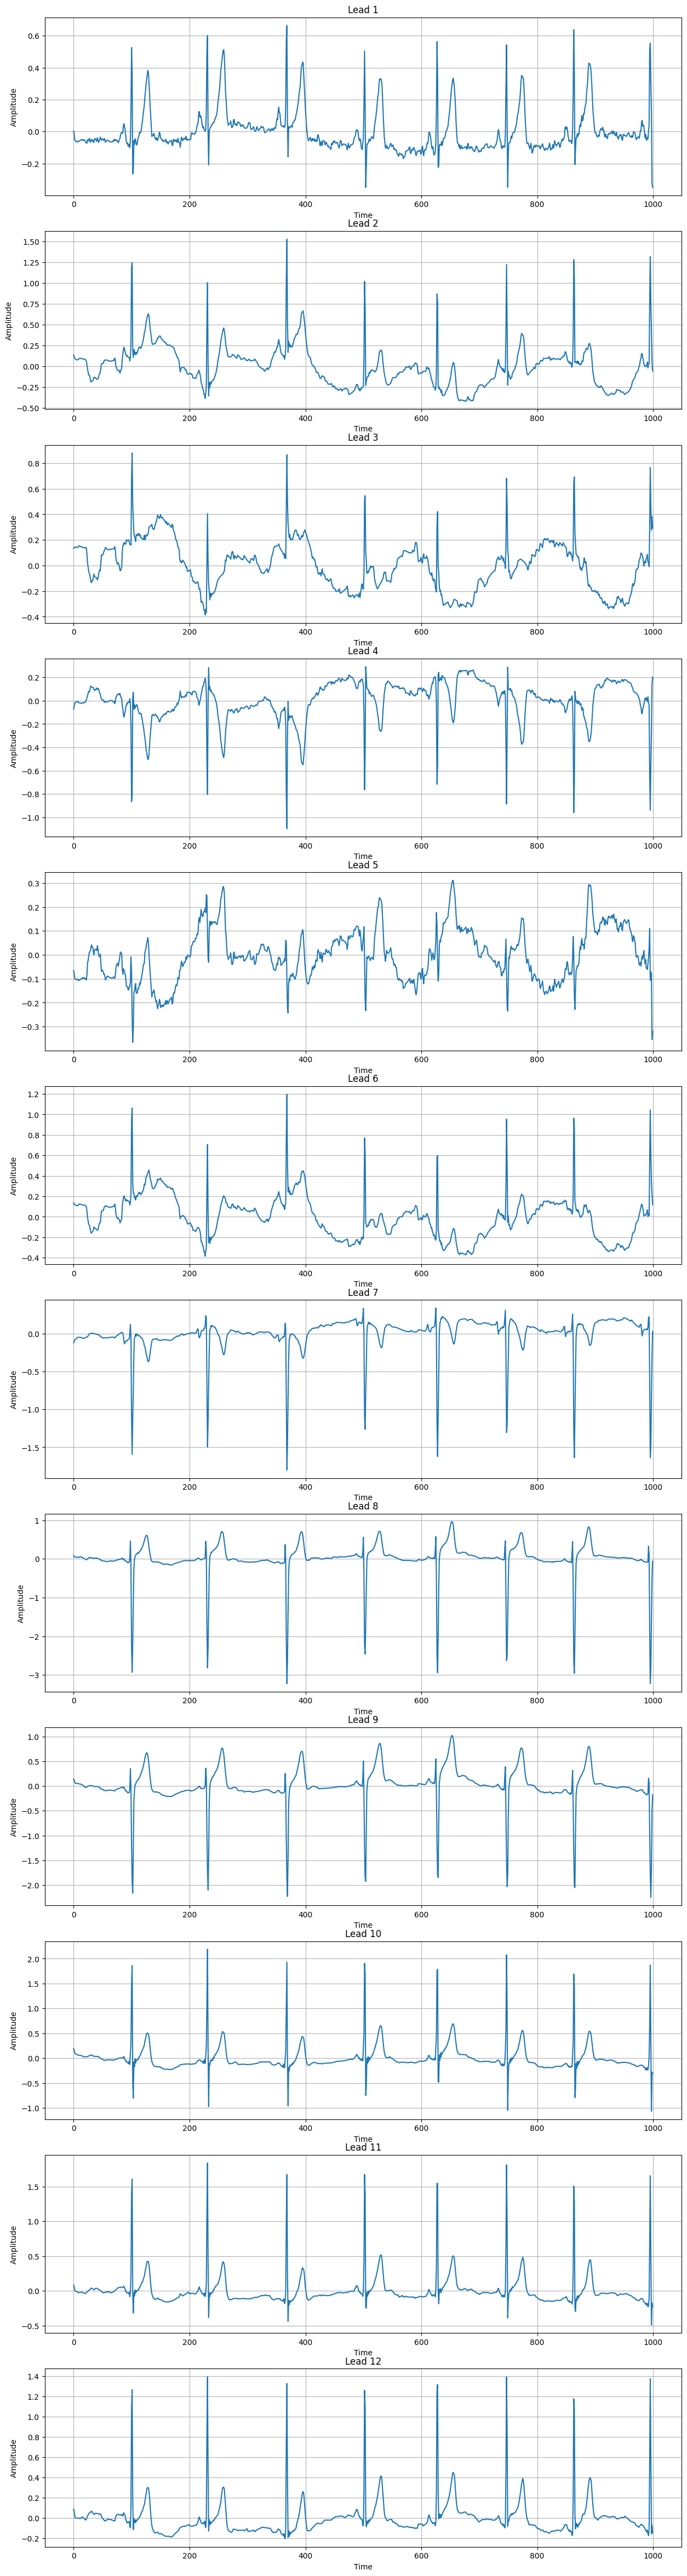

In [ ]:
#affiche multiple canal(combinaison de signaux provenant de differents electrodes):
num_leads = ecg_signal.shape[1]
plt.figure(figsize=(15, 5 * num_leads))
for i in range(num_leads):
    plt.subplot(num_leads, 1, i + 1)
    plt.plot(ecg_signal[:, i])
    plt.title(f"Lead {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)

Text(0, 0.5, 'Fréquence')

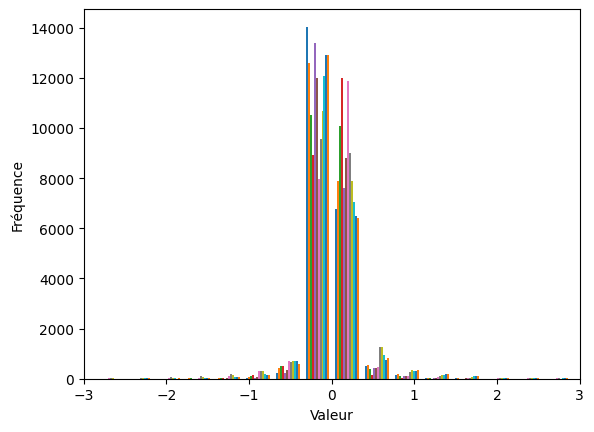

In [ ]:
 #for i in range(num_leads):
plt.hist(X[:, i], bins=50)  # Histogramme du lead 0
plt.xlabel("Valeur")
plt.xlim(-3, 3)
plt.ylabel("Fréquence")

### Visualisation après normalisation

8


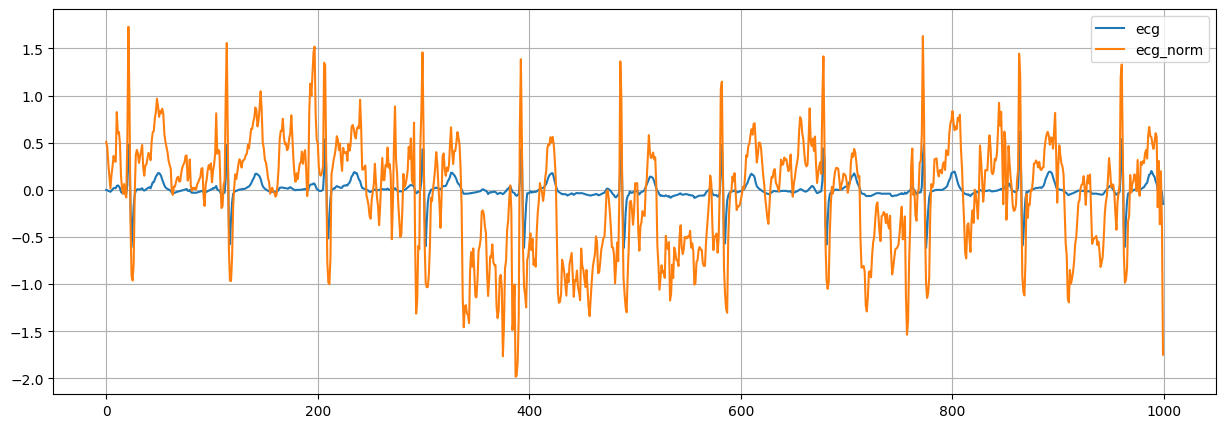

In [10]:
X_normalise = normalise_signaux(X)

1


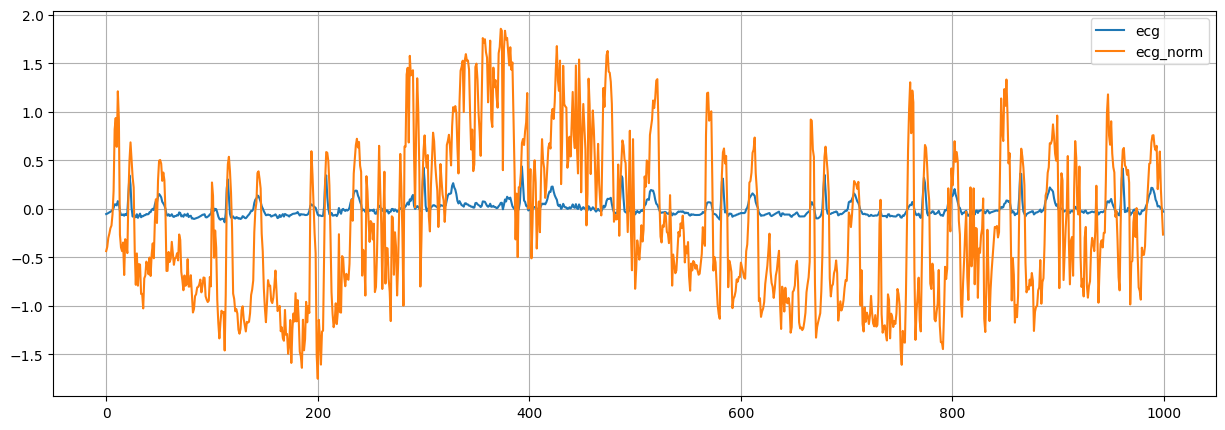

In [19]:
ecg_signal = X[0]
ecg_signal_norm = X_normalise[0]
canal = np.random.randint(0, X.shape[2])
print(canal)

plt.figure(figsize=(15, 5))
plt.plot(ecg_signal[:, canal], label = 'ecg')
plt.plot(ecg_signal_norm[:, canal], label = 'ecg_norm')
plt.legend()
plt.grid(True)